In [37]:
import pysam 
import pandas as pd 
import utils

In [8]:
df = pd.read_csv("/Users/zluo/TestData/GENCODE/GRCh38/gencode.v31.primary_assembly.protein_coding.exon.srt.bed",sep='\t', names=['chrom','start','end','name','score','strand'])

In [10]:
fa = pysam.FastaFile("/Users/zluo/TestData/GENCODE/GRCh38/Sequence/GRCh38.p13.genome.fa")

In [ ]:
gtf_gene, gtf_ts, gtf_exon, gtf_CDS = utils.parse_gtf("../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.gtf")

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

In [4]:
gtf_gene.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.gene.tab',sep='\t',index=False)
gtf_ts.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.ts.tab',sep='\t',index=False)
gtf_exon.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.exon.tab',sep='\t',index=False)
gtf_CDS.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.CDS.tab',sep='\t',index=False)

In [3]:
gtf_gene = pd.read_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.gene.tab',sep='\t')
gtf_ts = pd.read_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.ts.tab',sep='\t')
gtf_exon = pd.read_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.exon.tab',sep='\t')
gtf_CDS = pd.read_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.CDS.tab',sep='\t')

In [6]:
gtf_ts = utils.assign_cds_to_ts(gtf_ts, gtf_CDS)
gtf_ts.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.ts.tab',sep='\t',index=False)

In [ ]:
# assign cds to transcripts
gtf_ts = utils.assign_cds_to_ts(gtf_ts, gtf_CDS)
gtf_ts.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.ts.tab',sep='\t',index=False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/zluo/miniconda/envs/defcomp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-12c72d8bd63c>", line 2, in <module>
    gtf_ts = utils.assign_cds_to_ts(gtf_ts, gtf_CDS)
NameError: name 'utils' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zluo/miniconda/envs/defcomp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zluo/miniconda/envs/defcomp/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_line

In [5]:
gtf_gene_coding = gtf_gene[gtf_gene['gene_type'] == 'protein_coding']
gtf_ts_coding = gtf_ts[gtf_ts['gene_id'].isin(gtf_gene_coding['gene_id'])]
gtf_ts_coding_tsl1and2 = gtf_ts_coding[gtf_ts_coding['transcript_support_level'].isin(['1','2',1,2])]
gtf_exon_coding_tsl1and2 = gtf_exon[gtf_exon['transcript_id'].isin(gtf_ts_coding_tsl1and2['transcript_id'])]

In [15]:
gtf_gene_coding
gtf_ts_coding_tsl1and2_sample = gtf_ts_coding_tsl1and2.sample(n=1000, random_state=1992)
with open('/Users/zluo/TestData/GENCODE/GRCh38/gtf_ts_coding_tsl1and2_sample1000_intron.bed', 'w') as intron_bed:
    for idx, row in gtf_ts_coding_tsl1and2_sample.iterrows():
        ts_id = row['transcript_id']
        exons  = gtf_exon_coding_tsl1and2[gtf_exon_coding_tsl1and2['transcript_id'] == ts_id]
        exons = exons.sort_values('exon_number')
        exon_cnt = exons['exon_number'].max()
        if exon_cnt < 2:
            continue
        for idx_exon, exon in exons.iterrows():
            exon_number = exon['exon_number']
            if exon_number == 1:
                exon_end = int(exon['end'])
                continue
            else:
                exon_start = int(exon['start'])
                intron_start = exon_end
                intron_end = exon_start
                exon_end = int(exon['end'])
            intron_chrom = exon['seqname']
            intron_name = '{}:{}:{}'.format(exon['gene_name'],exon['transcript_id'],exon_number-1)
            intron_score = row['transcript_support_level']
            intron_strand = exon['strand']
            intron_bed.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(intron_chrom, intron_start, intron_end, intron_name, int(intron_score), intron_strand))

In [65]:
def get_alt_exons(gtf_ts, gtf_exon):
    gtf_exon = gtf_exon.to_dict('index')
    gtf_ts = gtf_ts.to_dict('index')
    gene_ts_cnt = dict()
    exon_usage = dict()
    ts_exon_dict = dict()
    for idx in gtf_exon:
        transcript_id = gtf_exon[idx]['transcript_id']
        if transcript_id not in ts_exon_dict:
            ts_exon_dict[transcript_id] = list()
        ts_exon_dict[transcript_id].append(idx)
    
    for idx in gtf_ts:
        gene_id = gtf_ts[idx]['gene_id']
        if gene_id not in gene_ts_cnt:
            gene_ts_cnt[gene_id] = 0
        gene_ts_cnt[gene_id] += 1
    
    for transcript_id in ts_exon_dict:
        exon_set = sorted(ts_exon_dict[transcript_id])
        exon_num = len(exon_set)
        for i, exon_idx in enumerate(exon_set):
            if i == 0 or i == exon_num - 1:
                continue

            gene_id = gtf_exon[exon_idx]['gene_id']
            exon_id = gtf_exon[exon_idx]['seqname'] + str(gtf_exon[exon_idx]['start']) + str(gtf_exon[exon_idx]['end']) + gtf_exon[exon_idx]['strand']
            if exon_id not in exon_usage:
                exon_usage[exon_id] = 0
            exon_usage[exon_id] += 1
    alt_exon_idx = list()
    alt_exon_coord = set()
    for idx in gtf_exon:
        exon_id = gtf_exon[idx]['seqname'] + str(gtf_exon[idx]['start']) + str(gtf_exon[idx]['end']) + gtf_exon[idx]['strand']
        gene_id = gtf_exon[idx]['gene_id']
        if exon_id in exon_usage and gene_id in gene_ts_cnt:
            if exon_usage[exon_id] != gene_ts_cnt[gene_id]:
                if exon_id not in alt_exon_coord:
                    alt_exon_idx.append(idx)
                    alt_exon_coord.add(exon_id)
                
    return alt_exon_idx

In [66]:
exon_idx_list = get_alt_exons(gtf_ts_coding_tsl1and2, gtf_exon)
gtf_exon_dict = gtf_exon.to_dict('index')

with open('/Users/zluo/TestData/GENCODE/GRCh38/gencode.v31.primary_assembly.coding.alt.exon.bed', 'w') as alt_exon:
    for idx in exon_idx_list:
        exon = gtf_exon_dict[idx]
        # gtf coordinates are 1-based, remember to covert to 0-based.
        alt_exon.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(exon['seqname'], exon['start']-1  , exon['end'], exon['exon_id'], '.', exon['strand']))

In [76]:
def get_introns(gtf_ts, gtf_exon):
    gtf_ts = gtf_ts.to_dict('index')
    gtf_exon = gtf_exon.to_dict('index')
    ts_exon_dict = dict()
    for idx in gtf_exon:
        transcript_id = gtf_exon[idx]['transcript_id']
        if transcript_id not in ts_exon_dict:
            ts_exon_dict[transcript_id] = list()
        ts_exon_dict[transcript_id].append(idx)
    
    for ts_idx in gtf_ts:
        transcript_id = gtf_ts[ts_idx]['transcript_id']
        exon_set = sorted(ts_exon_dict[transcript_id])
        exon_num = len(exon_set)
        if exon_num < 2:
            continue
        intron_chrom = gtf_ts[ts_idx]['seqname']
        intron_strand = gtf_ts[ts_idx]['strand']
        intron_start = 0
        intron_end = 0
        for i, exon_idx in enumerate(exon_set):
            if i == 0:
                if intron_strand == '+':
                    intron_start = gtf_exon[exon_idx]['end']
                else:
                    intron_end = gtf_exon[exon_idx]['start']
            else:
                if intron_strand == '+':
                    intron_end = gtf_exon[exon_idx]['start']
                else:
                    intron_start = gtf_exon[exon_idx]['end']
                intron_name = transcript_id+'_'+str(i)
                yield '{}\t{}\t{}\t{}\t{}\t{}\n'.format(intron_chrom, intron_start, intron_end, intron_name, '.', intron_strand)
                if intron_strand == '+':
                    intron_start = gtf_exon[exon_idx]['end']
                else:
                    intron_end = gtf_exon[exon_idx]['start']

In [77]:
with open('/Users/zluo/TestData/GENCODE/GRCh38/gencode.v31.primary_assembly.coding.intron.bed', 'w') as intron_bed:
    for intron in get_introns(gtf_ts_coding_tsl1and2, gtf_exon):
        intron_bed.write(intron)

In [40]:
event_stat = pd.read_csv("~/TestData/event_stat.tab", sep='\t')
gtf_ts['start'] = pd.to_numeric(gtf_ts['start'])
gtf_ts['end'] = pd.to_numeric(gtf_ts['end'])
event_dis_stat = list()
for idx, event in event_stat.iterrows():
    coord = event['coord']
    chrom = coord.split(':')[0]
    strand = coord.split(':')[2]
    start = int(coord.split(':')[1].split('-')[0])
    end = int(coord.split(':')[1].split('-')[1])
    protein = event['protein']
    #if 'PABPC1' not in protein.split(','):
        #continue
    target_ts = gtf_ts[gtf_ts['seqname']==chrom]
    target_ts = target_ts[target_ts['strand']==strand]
    target_ts = target_ts[(target_ts['start']<= start) & (target_ts['end']>=end)]
    target_ts = target_ts.head(1)
    if strand == '+':
        dis_abs =  int(target_ts['end'] - start)
        dis_prop = float((start - target_ts['start']) / (target_ts['end'] -target_ts['start']))
    else:
        dis_abs = int(end - target_ts['start'])
        dis_prop = float((end - target_ts['start']) / (target_ts['end'] -target_ts['start']))
    event_dis_stat.append([dis_abs, dis_prop])
event_dis_stat = pd.DataFrame(event_dis_stat, columns=['dis_abs','dis_prop'])

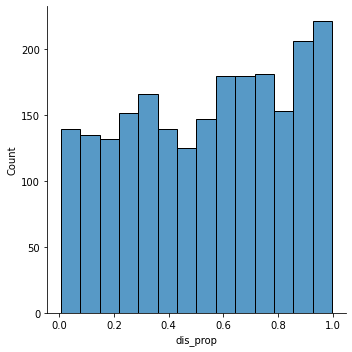

In [41]:
import seaborn as sns

ax = sns.displot(x='dis_prop',  data=event_dis_stat)
#_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
